# Imports

In [1]:
import sys
sys.path.append("../")
import os
import torch
from classifier.DataModule import DataModule
from explainer.Explainer import Explainer
import numpy as np
import yaml
import matplotlib.pyplot as plt
import torchvision

# Initialize

In [2]:
config_path = '../configs/celebA_Young_Explainer.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)

config['cls_experiment'] = '.' + config['cls_experiment']
config['image_label_dict'] = '.' + config['image_label_dict']

ckpt_dir_cls = config['cls_experiment']
assets_dir = os.path.join('.' + config['log_dir'], config['name'])
log_dir = os.path.join(assets_dir, 'log')
n_bins = config['num_bins']

print(config)

{'image_label_dict': '../output/classifier/CelebA-Young/explainer_input/list_attr_celeba_Young.txt', 'cls_experiment': '../checkpoints/classifier/CelebA-Young', 'log_dir': './output/explainer', 'name': 'CelebA-Young-Binary', 'num_channel': 3, 'num_class': 1, 'num_bins': 10, 'target_class': 1, 'input_size': 128, 'batch_size': 8, 'epochs': 300, 'lambda_GAN': 1, 'lambda_cyc': 100, 'lambda_cls': 1, 'save_summary': 20, 'ckpt_dir_continue': './output/explainer/CelebA-Young-Binary', 'count_to_save': 20}


# Load trained Explainer model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

explainer = Explainer(config)
exp_ckpt_path = os.path.join('../checkpoints/explainer', config['name'], 'last.ckpt')
exp_ckpt = torch.load(exp_ckpt_path)
explainer.load_state_dict(exp_ckpt['state_dict'])
explainer.eval()
explainer = explainer.to(device)

# Run an experiment

In [4]:
ckpt_dir_cls

'../checkpoints/classifier/CelebA-Young'

In [5]:
def read_data_file(file_path, image_dir=''):
    attr_list = {}
    
    file = open(file_path,'r')
    
    n = file.readline()
    n = int(n.split('\n')[0]) #  Number of images
    
    attr_line = file.readline()
    attr_names = attr_line.split('\n')[0].split() # attribute name
    
    for line in file:
        row = line.split('\n')[0].split()
        img_name = os.path.join(image_dir, row.pop(0))
        try:
            row = [float(val) for val in row]
        except:
            print(line)
            img_name = img_name + ' ' + row[0]
            row.pop(0)
            row = [float(val) for val in row]
            
        attr_list[img_name] = row
    
    file.close()
    
    return attr_names, attr_list

In [6]:
try:
    categories, file_names_dict = read_data_file(config['image_label_dict'])
except:
    print("Problem in reading input data file : ", config['image_label_dict'])
    sys.exit()

data = np.asarray(list(file_names_dict.keys()))

print("The classification categories are: ")
print(categories)
print('The size of the training set: ', len(data))

data[0 : 10]

The classification categories are: 
['0-0.09', '0.1-0.19', '0.2-0.29', '0.3-0.39', '0.4-0.49', '0.5-0.59', '0.6-0.69', '0.7-0.79', '0.8-0.89', '0.9-0.99']
The size of the training set:  43041


array(['./data/CelebA/images/135494.jpg',
       './data/CelebA/images/111493.jpg',
       './data/CelebA/images/095514.jpg',
       './data/CelebA/images/152705.jpg',
       './data/CelebA/images/070325.jpg',
       './data/CelebA/images/135886.jpg',
       './data/CelebA/images/162425.jpg',
       './data/CelebA/images/088274.jpg',
       './data/CelebA/images/161387.jpg',
       './data/CelebA/images/175339.jpg'], dtype='<U31')

In [7]:
config['batch_size'] = 3
data_module = DataModule(config, to_explainer=True, append_to_path='.')
train_dataset = data_module.train_dataset
train_dataloader = data_module.train_dataloader()

In [8]:
fake_images = np.empty([])
real_predictions = np.empty([])
fake_predictions = np.empty([])
real_images = np.empty([])

In [9]:
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx == 2:
        break
        
    images, labels = batch
    print("Size of source images: ", images.shape)
    
    target_labels = torch.tensor([range(n_bins) for j in range(images.shape[0])])
    target_labels = torch.reshape(target_labels, shape=[-1])
    print("Size of target labels: ", target_labels.shape)
    
    images_repeat = torch.repeat_interleave(images, n_bins, 0)
    
    fake_target_images, _ = explainer.G(images_repeat.to(device), target_labels.to(device))
    fake_target_images = fake_target_images.detach()
    
    real_preds = torch.sigmoid(explainer.model(images_repeat.to(device)))
    real_preds = real_preds.detach()
    
    fake_preds = torch.sigmoid(explainer.model(fake_target_images.to(device)))
    fake_preds = fake_preds.detach()
    
    if batch_idx == 0:
        real_images = images.cpu()
        fake_images = fake_target_images.cpu()
        real_predictions = real_preds.cpu()
        fake_predictions = fake_preds.cpu()
    else: 
        real_images = np.append(real_images, images.cpu(), axis=0)
        fake_images = np.append(fake_images, fake_target_images.cpu(), axis=0)
        real_predictions = np.append(real_predictions, real_preds.cpu(), axis=0)
        fake_predictions = np.append(fake_predictions, fake_preds.cpu(), axis=0)

real_images = torch.tensor(real_images)
fake_images = torch.tensor(fake_images)
real_predictions = torch.tensor(real_predictions)
fake_predictions = torch.tensor(fake_predictions)

print(real_images.shape)
print(fake_images.shape)
print(real_predictions.shape)
print(fake_predictions.shape)

Size of source images:  torch.Size([3, 3, 128, 128])
Size of target labels:  torch.Size([30])
Size of source images:  torch.Size([3, 3, 128, 128])
Size of target labels:  torch.Size([30])
torch.Size([6, 3, 128, 128])
torch.Size([60, 3, 128, 128])
torch.Size([60, 1])
torch.Size([60, 1])


# View

In [10]:
def view(img, n_bins, real_pred, fake_img, fake_pred):
    start = 0
    fake_pred = np.round(fake_pred, decimals=2)
    for i in range(3):
        plt.figure(figsize=(3, 3))
        plt.imshow(img[i].permute(1, 2, 0))
        plt.title(f'Output of pre. cls: {real_pred[start].item()}')
        plt.show()
        
        plt.figure(figsize=(20, 20))
        grid_fake_img = torchvision.utils.make_grid(fake_img[start : start + n_bins], nrow=n_bins)
        
        fake_predictions = fake_pred[start : start + n_bins].squeeze().tolist()
        fake_predictions = list(np.around(np.array(fake_predictions), 2))
        plt.title(f'Generated image cls output: {fake_predictions}')
        plt.imshow(grid_fake_img.permute(1, 2, 0))
        plt.show()

        start = start + n_bins

# Save Results

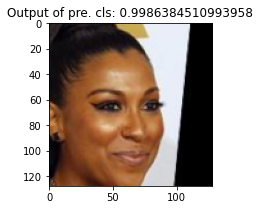

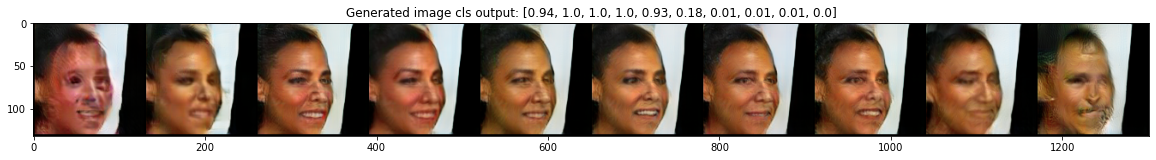

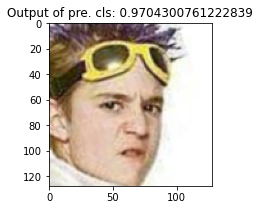

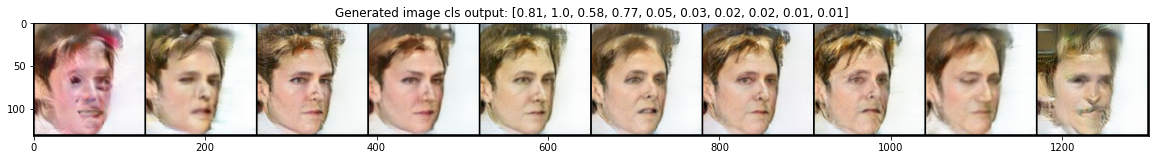

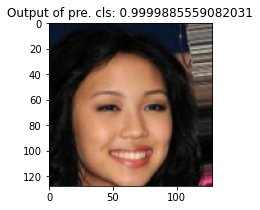

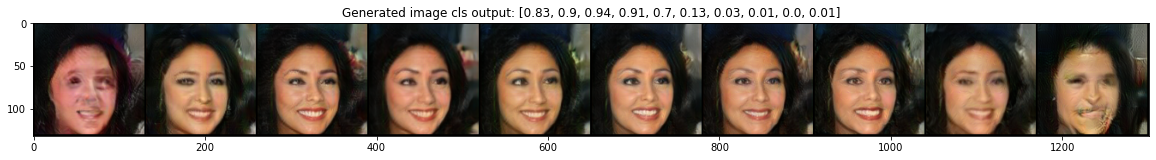

In [12]:
view(real_images[0 : 3] * 0.5 + 0.5, 10, real_predictions[0 : 30], fake_images[0 : 30] * 0.5 + 0.5, fake_predictions[0 : 30])